In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm ##qq plots
import numpy as np
import pandas as pd
from scipy.special import softmax

import utils.multicrop_dataset as multicrop_dataset
import utils.architecture as architecture

tf.random.set_seed(0)
np.random.seed(0)


options = tf.data.Options()
options.experimental_optimization.noop_elimination = True             # eliminate no-op transformations
tf.compat.v1.data.experimental.OptimizationOptions.map_vectorization = True    # vectorize map transformations
options.experimental_optimization.apply_default_optimizations = True  # apply default graph optimizations
options.experimental_deterministic = True                            # False disable deterministic order
options.threading.max_intra_op_parallelism = 1           # overrides the maximum degree of intra-op parallelism 

In [6]:
import xarray as xr
import numpy as np
from time import sleep

def open_nc(file_path):

    try:
        ds = xr.open_dataset(file_path)

    except Exception as e:
        print(f"Error opening file: {e}")
        return 

    else:
        return ds
    
def get_values(variable, file= 'data/msl_t2m_1983_2023.nc',wind = 4, quantile=False):
    #just to save process

    ds = open_nc(file)
    df = ds[variable].values

    if quantile:
        max_o = np.quantile(df,0.99)
        min_o = np.quantile(df,0.1)

        df = np.clip(df, min_o, max_o)

    else:
        min_o = np.min(df)
        max_o = np.max(df)

    norm_imgs = (df - min_o)/(max_o -min_o)

    time, lat, long = norm_imgs.shape

    norm_imgs = norm_imgs.reshape(int(time/wind), wind, lat, long)
    norm_imgs = np.transpose(norm_imgs, (0, 2, 3, 1))

    # np.save(f'data/{variable}',norm_imgs,allow_pickle=False)

    return norm_imgs

DATA_WIND = 4
VARIABLE = 't2m'
data = get_values('t2m',wind=DATA_WIND)

In [7]:
BS = 512
SIZE_CROPS = [50, 32]  
NUM_CROPS= [2,3]

#SCALE FOR CROPPING
MIN_SCALE = [0.7, 0.5]
MAX_SCALE = [1., 0.7]

PROTOTYPES = 30
PROPORTIONS = [] #to not use proportions declare it as empty list

#check
if len(PROPORTIONS):
    PROTOTYPES = len(PROPORTIONS)

MODEL_TAG  = f'{VARIABLE}_{PROTOTYPES}_bs{BS}_wind{DATA_WIND}'

In [8]:
# data = np.load('data/test.npy')
data_tensors = tf.data.Dataset.from_tensor_slices(data) 

# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(data_tensors,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

trainloaders_zipped = (
        trainloaders_zipped
        .batch(BS)
        .prefetch( tf.data.experimental.AUTOTUNE)
    )

2024-08-13 10:30:59.678678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_40' with dtype float and shape [29950,143,142,4]
	 [[{{node Placeholder/_40}}]]
2024-08-13 10:30:59.679091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [29950,143,142,4]
	 [[{{node Placeholder/_20}}]]


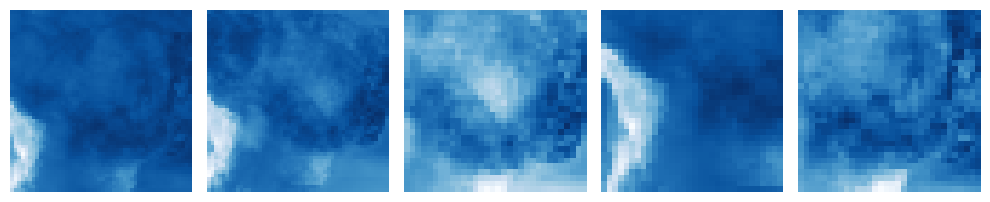

In [84]:
images = [i[3] for i in next(iter(trainloaders_zipped))]

fig, axes = plt.subplots(1, 5, figsize=(10, 7))

for ax, img in zip(axes.ravel(), images):
    
    ax.imshow(img,cmap='Blues')
    ax.axis('off')


for ax in axes.ravel()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(prototype_dimension = PROTOTYPES)

In [88]:
decay_steps = 1000

lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [17]:
# tf.keras.backend.clear_session()

In [10]:
try: 
    feature_backbone.load_weights(f'model_weights/feature2d_{MODEL_TAG}.h5')
    projection_prototype.load_weights(f'model_weights/proj2d_{MODEL_TAG}.h5')

except:
    print(MODEL_TAG,"not found")

In [98]:
epoch_wise_loss, models_tr = architecture.train_swav(feature_backbone,projection_prototype,
                                        trainloaders_zipped,opt,
                                        crops_for_assign=[0, 1],temperature=0.1,epochs=100,
                                        n_crops = NUM_CROPS, proto_proportions = PROPORTIONS,model_name=MODEL_TAG)

feature_backbone_weights = feature_backbone.get_weights()

  0%|          | 0/59 [00:00<?, ?it/s]

2024-08-13 10:35:04.659612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2024-08-13 10:35:04.856486: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-13 10:35:12.783674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-13 10:36:06.531786: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5ae4a1068dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-13 10:36:06.531814: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-13 10:36:06.636045: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-13 10:36:06.674918: I ./tensorflow/compiler/jit/device_compiler

100%|██████████| 59/59 [02:00<00:00,  2.05s/it, loss=3.396] 


epoch: 1 loss: 3.438
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=3.210]


epoch: 2 loss: 3.388
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=2.876]


epoch: 3 loss: 3.258
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=2.669]


epoch: 4 loss: 3.122
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=2.449]


epoch: 5 loss: 2.999
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=2.235]


epoch: 6 loss: 2.885
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=2.094]


epoch: 7 loss: 2.778
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.805]


epoch: 8 loss: 2.674
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.738]


epoch: 9 loss: 2.573
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.515]


epoch: 10 loss: 2.479
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.439]


epoch: 11 loss: 2.389
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.347]


epoch: 12 loss: 2.305
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.337]


epoch: 13 loss: 2.228
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.256]


epoch: 14 loss: 2.158
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.277]


epoch: 15 loss: 2.096
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.233]


epoch: 16 loss: 2.041
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.246]


epoch: 17 loss: 1.992
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.259]


epoch: 18 loss: 1.949
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.263]


epoch: 19 loss: 1.910
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.202]


epoch: 20 loss: 1.875
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.295]


epoch: 21 loss: 1.843
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.272]


epoch: 22 loss: 1.814
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.217]


epoch: 23 loss: 1.788
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.296]


epoch: 24 loss: 1.764
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.254]


epoch: 25 loss: 1.742
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.258]


epoch: 26 loss: 1.721
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.307]


epoch: 27 loss: 1.702
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.239]


epoch: 28 loss: 1.685
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.239]


epoch: 29 loss: 1.668
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.313]


epoch: 30 loss: 1.653
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.309]


epoch: 31 loss: 1.639
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.221]


epoch: 32 loss: 1.625
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.305]


epoch: 33 loss: 1.613
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.240]


epoch: 34 loss: 1.601
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.298]


epoch: 35 loss: 1.590
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.223]


epoch: 36 loss: 1.579
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.213]


epoch: 37 loss: 1.569
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.258]


epoch: 38 loss: 1.559
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.224]


epoch: 39 loss: 1.550
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.274]


epoch: 40 loss: 1.542
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.224]


epoch: 41 loss: 1.534
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.238]


epoch: 42 loss: 1.526
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.234]


epoch: 43 loss: 1.518
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.294]


epoch: 44 loss: 1.511
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.273]


epoch: 45 loss: 1.505
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.247]


epoch: 46 loss: 1.498
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.280]


epoch: 47 loss: 1.492
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.268]


epoch: 48 loss: 1.486
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.253]


epoch: 49 loss: 1.481
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.251]


epoch: 50 loss: 1.475
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.277]


epoch: 51 loss: 1.470
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.279]


epoch: 52 loss: 1.465
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.255]


epoch: 53 loss: 1.460
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.271]


epoch: 54 loss: 1.455
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.329]


epoch: 55 loss: 1.451
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.225]


epoch: 56 loss: 1.446
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.269]


epoch: 57 loss: 1.442
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.243]


epoch: 58 loss: 1.438
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.281]


epoch: 59 loss: 1.434
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.307]


epoch: 60 loss: 1.431
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.321]


epoch: 61 loss: 1.427
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.248]


epoch: 62 loss: 1.423
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.284]


epoch: 63 loss: 1.420
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.267]


epoch: 64 loss: 1.417
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.271]


epoch: 65 loss: 1.413
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.220]


epoch: 66 loss: 1.410
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.279]


epoch: 67 loss: 1.407
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.298]


epoch: 68 loss: 1.404
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.231]


epoch: 69 loss: 1.402
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.298]


epoch: 70 loss: 1.399
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.274]


epoch: 71 loss: 1.396
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.283]


epoch: 72 loss: 1.394
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.312]


epoch: 73 loss: 1.391
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.272]


epoch: 74 loss: 1.389
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.260]


epoch: 75 loss: 1.386
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.239]


epoch: 76 loss: 1.384
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.311]


epoch: 77 loss: 1.382
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.275]


epoch: 78 loss: 1.379
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.254]


epoch: 79 loss: 1.377
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.274]


epoch: 80 loss: 1.375
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.318]


epoch: 81 loss: 1.373
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.193]


epoch: 82 loss: 1.371
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.204]


epoch: 83 loss: 1.369
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.257]


epoch: 84 loss: 1.367
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.259]


epoch: 85 loss: 1.366
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.222]


epoch: 86 loss: 1.364
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.259]


epoch: 87 loss: 1.362
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.281]


epoch: 88 loss: 1.360
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.168]


epoch: 89 loss: 1.359
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.317]


epoch: 90 loss: 1.357
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.209]


epoch: 91 loss: 1.355
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.276]


epoch: 92 loss: 1.354
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.293]


epoch: 93 loss: 1.352
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.336]


epoch: 94 loss: 1.351
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.299]


epoch: 95 loss: 1.349
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.250]


epoch: 96 loss: 1.348
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.193]


epoch: 97 loss: 1.346
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.259]


epoch: 98 loss: 1.345
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.248]


epoch: 99 loss: 1.343
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.179]


epoch: 100 loss: 1.342
Saving weights


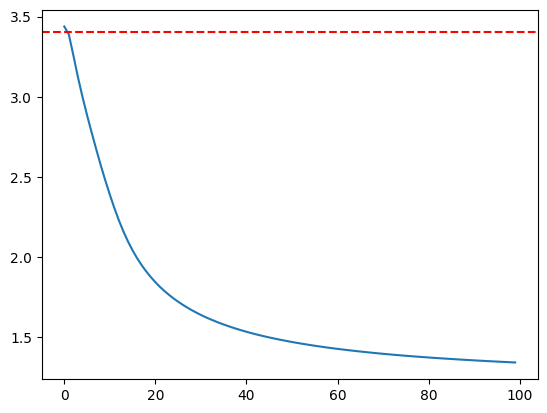

In [100]:
plt.plot(epoch_wise_loss, label='Epoch-wise Loss')
plt.axhline(y=np.log(PROTOTYPES), color='r', linestyle='--', label='ln(#prototypes)')

plt.show()

## Get assigments:

In [11]:
final_data = []
for sample in data:

    for v in range(sample.shape[-1]):
        final_data.append(sample[:,:,v])

In [24]:
try:
    assignments = np.load(f'model_weights/assignments_{MODEL_TAG}.npy',allow_pickle=False)

except:
    blocks=100
    size = int(len(final_data)/blocks)

    for i in range(blocks):

        embeddings_ = feature_backbone(np.asarray(final_data)[i*size:(i+1)*size])
        projection_, prototype_ = projection_prototype(embeddings_)

        if i == 0:
            prototype=np.asarray(prototype_)
        else:
            prototype=np.concatenate([prototype,np.asarray(prototype_)])

    prototype = np.asarray(prototype)
    del projection_,embeddings_

    assignments = np.argmax(softmax(prototype),axis=1)
    np.save(f'model_weights/assignments_{MODEL_TAG}',assignments,allow_pickle=False)

## Simple plots

In [104]:
min_samples= 500
max_samples= len(final_data)

colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]
test_data_list = np.asarray(final_data)

Cluster: 0 Shape: (2249, 143, 142) Avg: 0.6997021 Std: 0.05591007


/u00/livia.meinhardt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Cluster: 2 Shape: (721, 143, 142) Avg: 0.65223294 Std: 0.096848525
Cluster: 3 Shape: (16051, 143, 142) Avg: 0.7451667 Std: 0.059284266
Cluster: 4 Shape: (2475, 143, 142) Avg: 0.6953507 Std: 0.07158145
Cluster: 5 Shape: (9019, 143, 142) Avg: 0.68923956 Std: 0.06550618
Cluster: 6 Shape: (17294, 143, 142) Avg: 0.67796546 Std: 0.06884494
Cluster: 7 Shape: (1860, 143, 142) Avg: 0.71915793 Std: 0.07936309
Cluster: 8 Shape: (4780, 143, 142) Avg: 0.7572288 Std: 0.07861796
Cluster: 9 Shape: (1188, 143, 142) Avg: 0.7247843 Std: 0.05219062
Cluster: 10 Shape: (11343, 143, 142) Avg: 0.6903844 Std: 0.060207892
Cluster: 11 Shape: (5804, 143, 142) Avg: 0.70833206 Std: 0.05621341
Cluster: 12 Shape: (976, 143, 142) Avg: 0.72164595 Std: 0.05604127
Cluster: 13 Shape: (914, 143, 142) Avg: 0.66828096 Std: 0.09425823
Cluster: 16 Shape: (645, 143, 142) Avg: 0.74354744 Std: 0.060265616
Cluster: 17 Shape: (674, 143, 142) Avg: 0.71367353 Std: 0.061816838
Cluster: 18 Shape: (1809, 143, 142) Avg: 0.7373805 Std: 0.

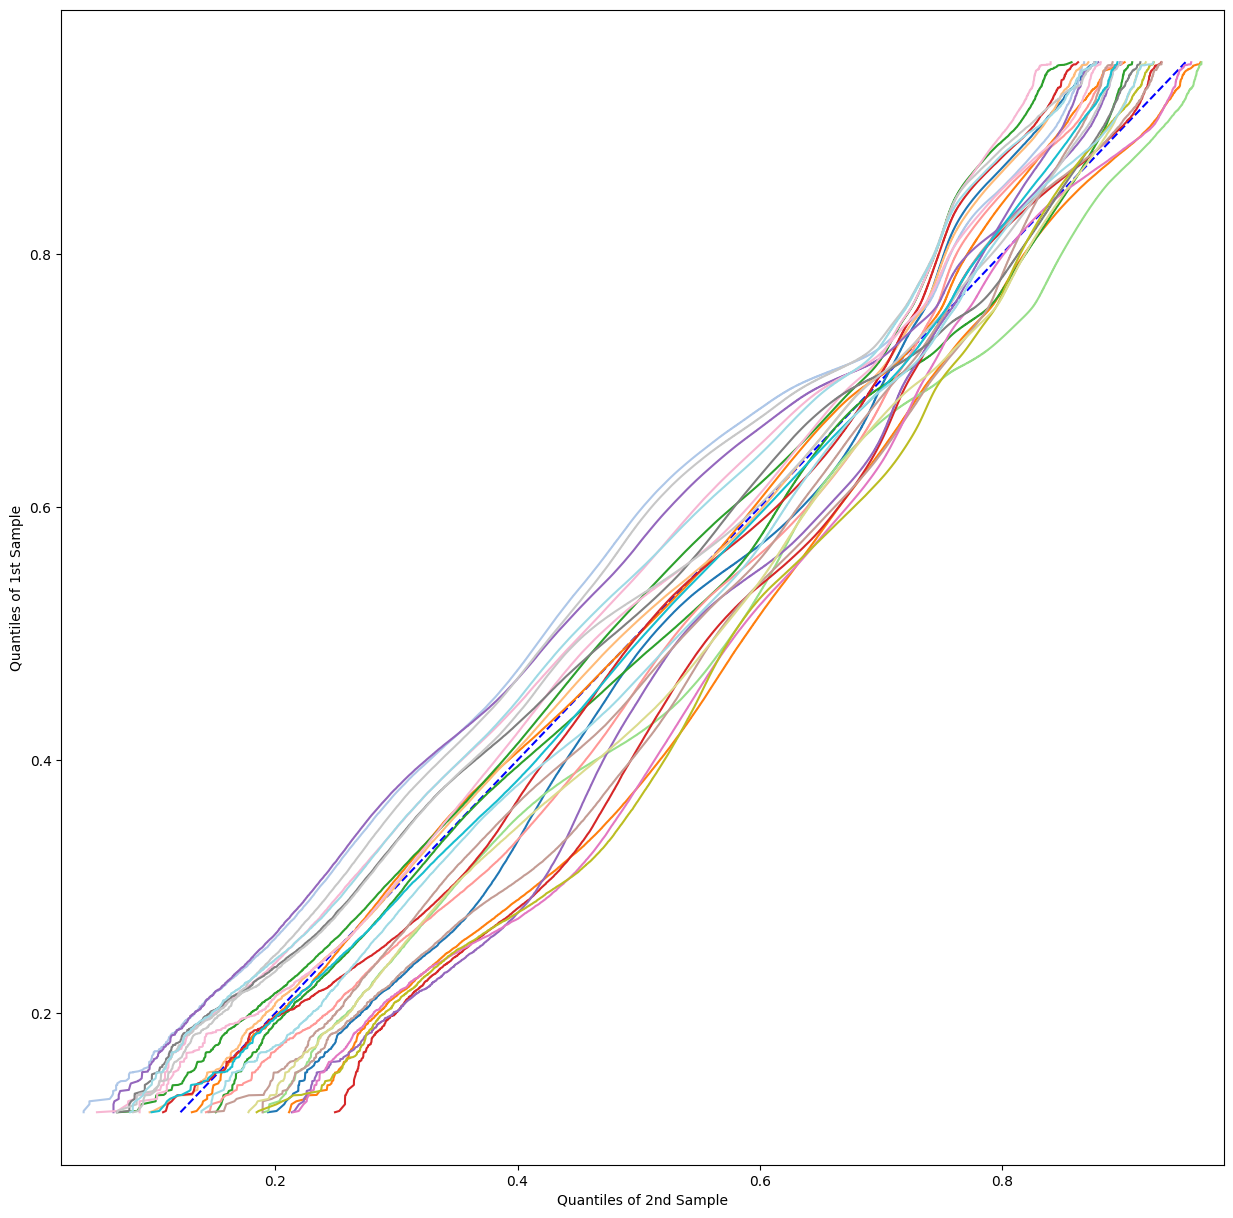

In [105]:
random_samples_ids = np.random.choice(range(test_data_list.shape[0]),size=min_samples) #random samples to QQPLOT
colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]

fig, ax = plt.subplots(figsize=(15, 15))

pplot  = sm.ProbPlot(data=test_data_list[random_samples_ids].ravel())
pplot.qqplot(other=pplot,ax=ax, marker='', linestyle='dashed',label= 'self') #45 line

for num, cluster in enumerate(range(PROTOTYPES)): #iterates over each cluster (uses num to get new color)
    
    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
        
#         if num in [3,11]:
        #show cluster stats
        print('Cluster:',cluster,'Shape:', cur_cluster_shape,  'Avg:',np.mean(cur_cluster.ravel()),  'Std:', np.std(cur_cluster.ravel()))

        random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

        cur_color = colors_c[num] 
        pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color=cur_color,
                        label= f'{cluster}: {cur_cluster_shape[0]}')

#         else:
#             random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

#             pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color='lightgrey',
#                           label= f'{cluster}: {cur_cluster_shape[0]}')

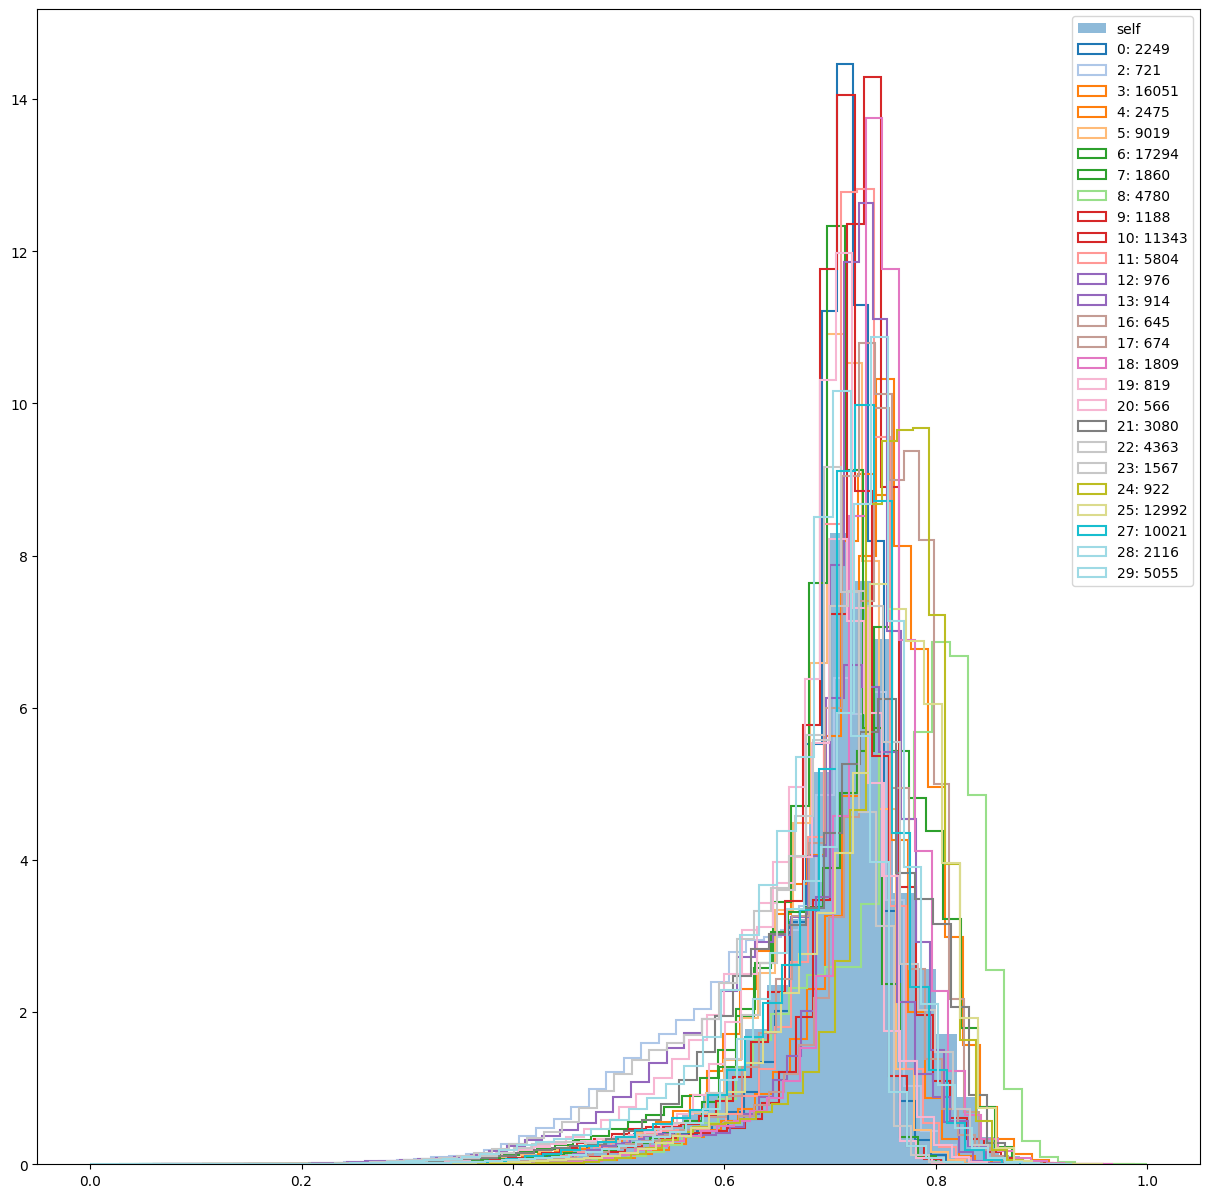

In [106]:
n_bins = 50

fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(test_data_list.ravel(),density=True,bins=n_bins,alpha = 0.5,label= 'self')

for num, cluster in enumerate(range(PROTOTYPES)):
    

    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
            
#         if num in []:

            plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color=colors_c[num],label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=1.5)
        
#         else:
#                  plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color='lightgrey',label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=0.5)
        

plt.legend()

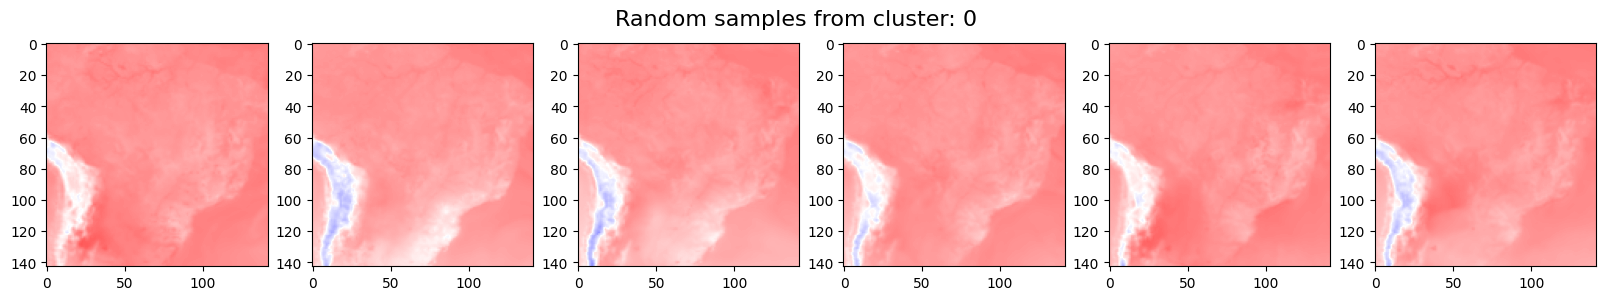

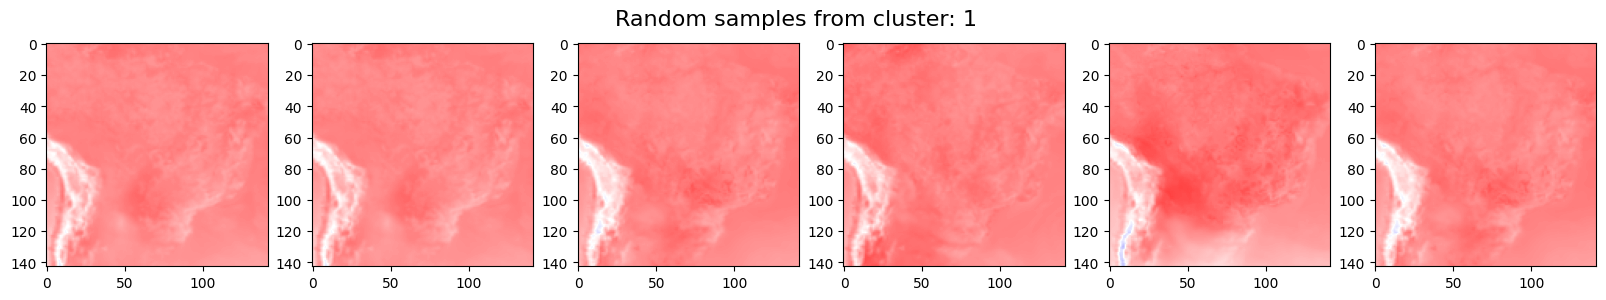

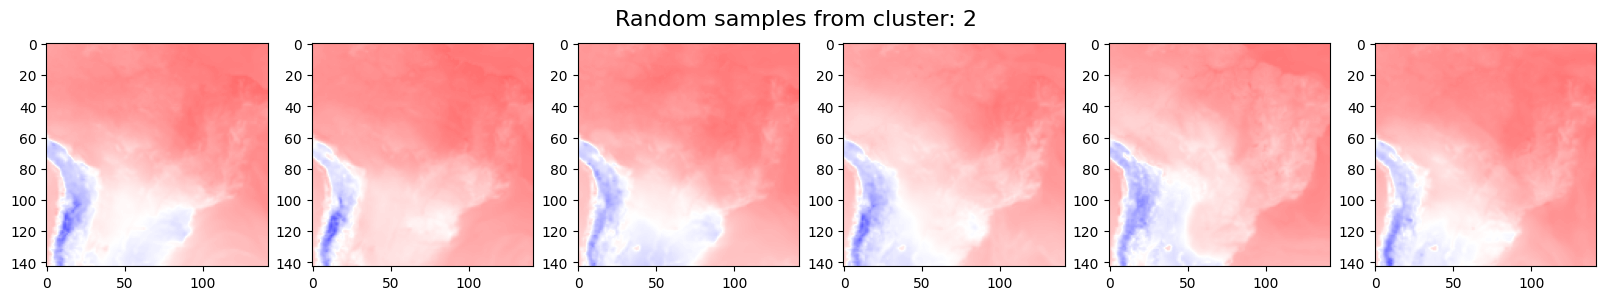

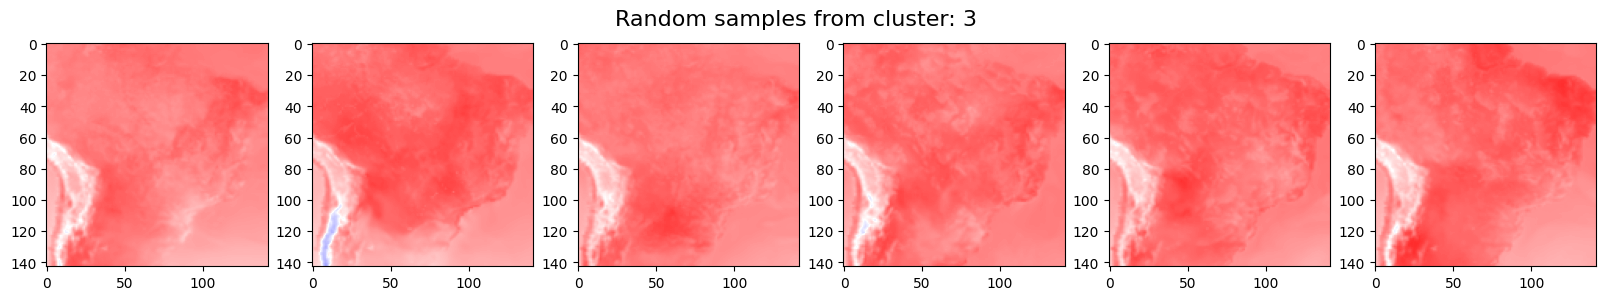

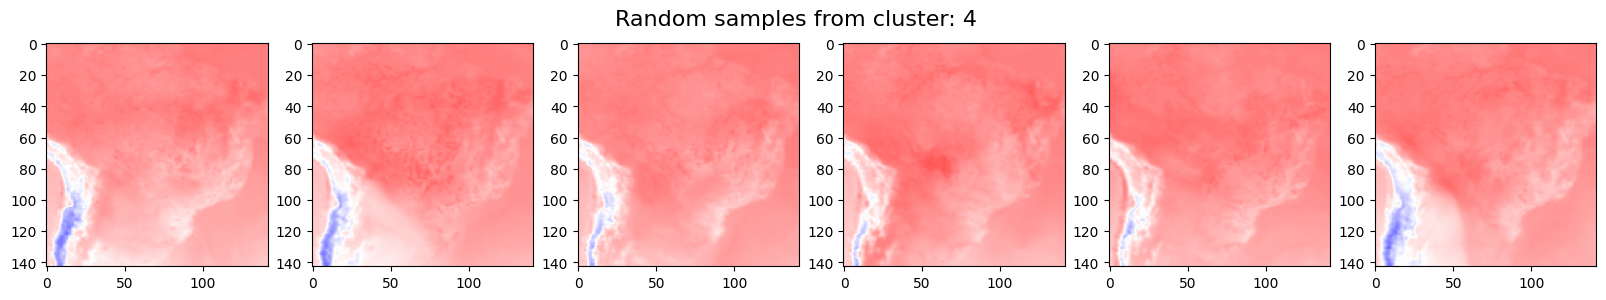

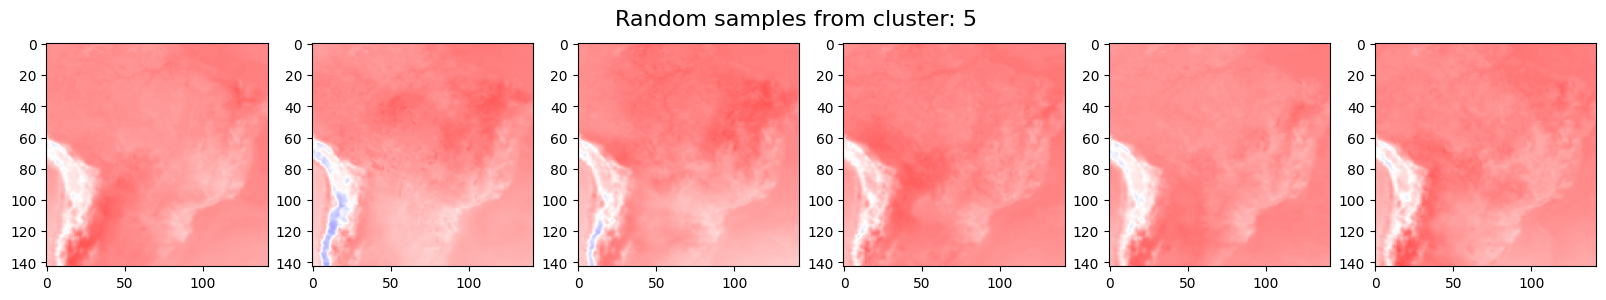

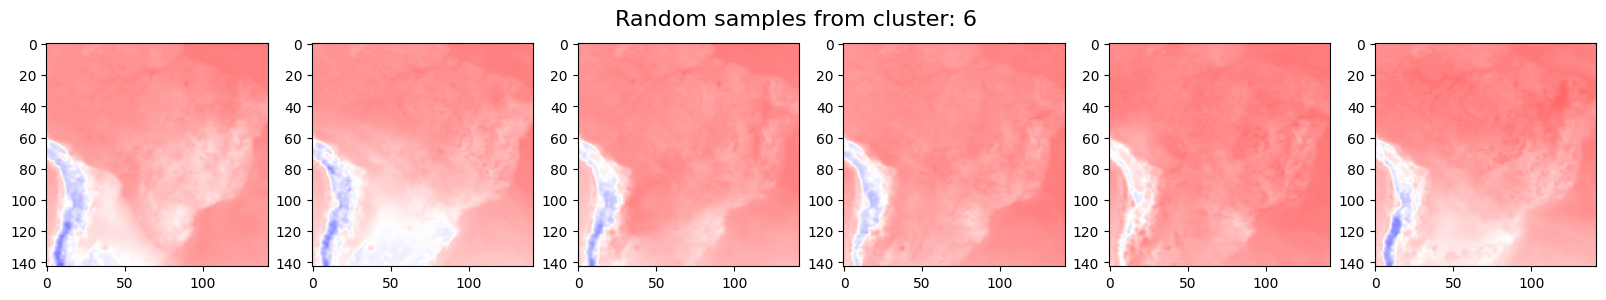

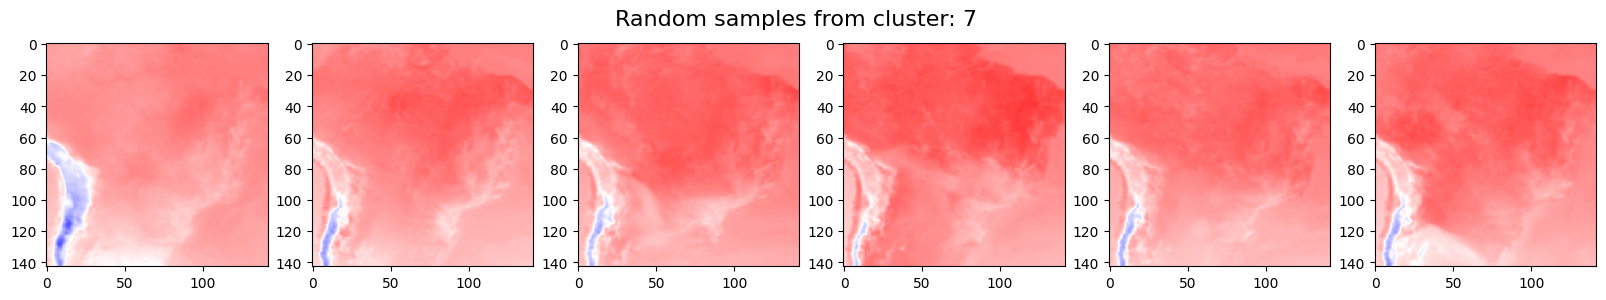

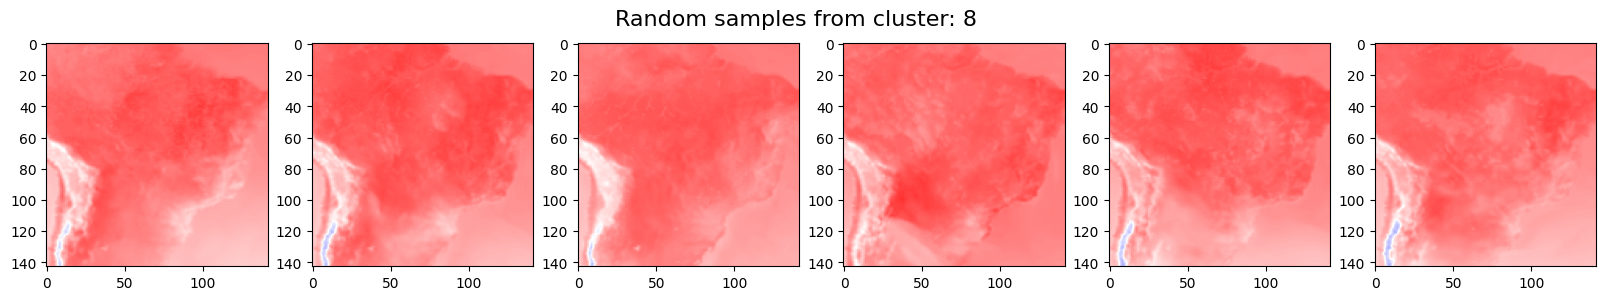

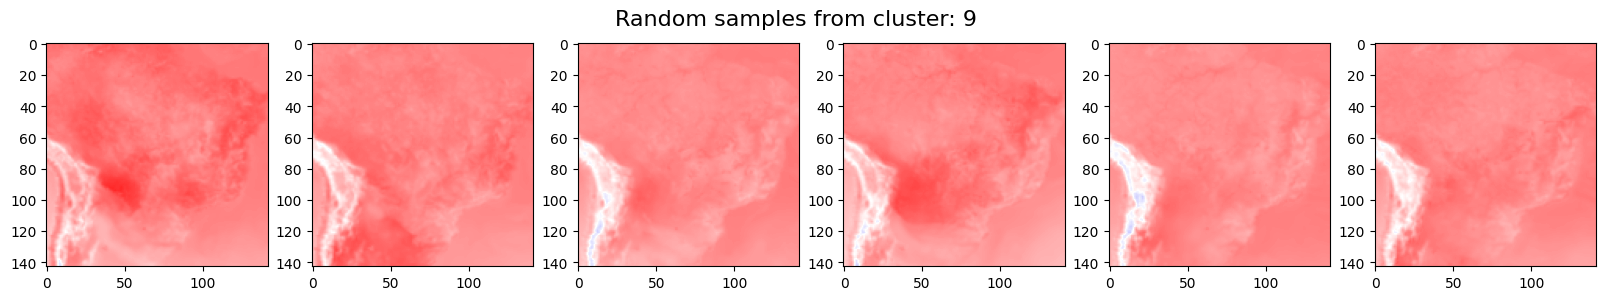

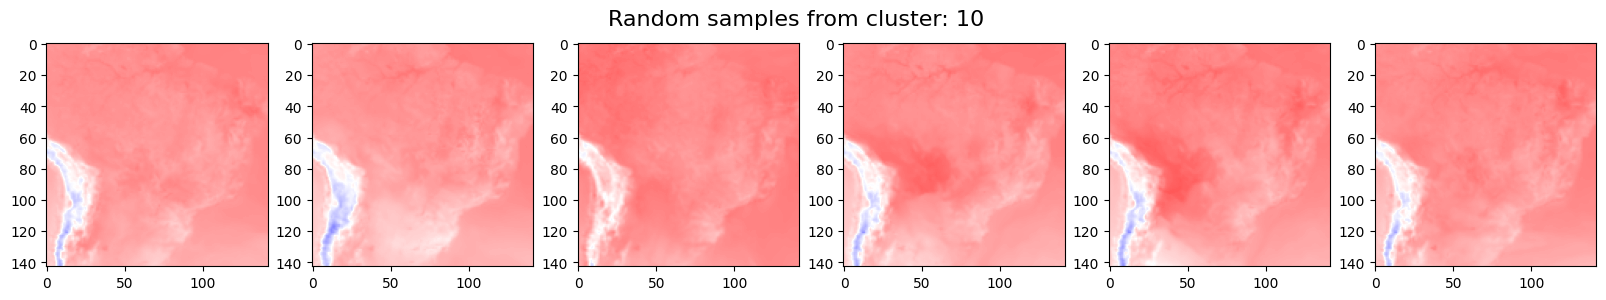

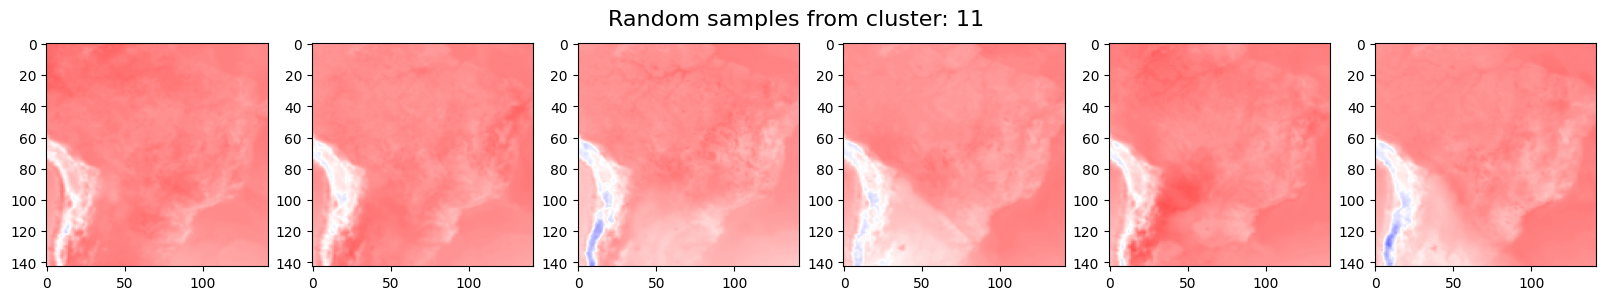

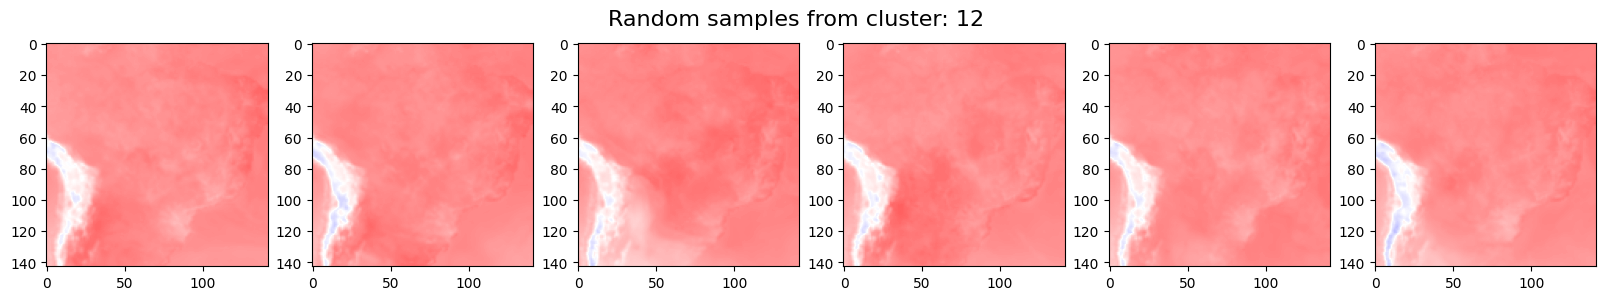

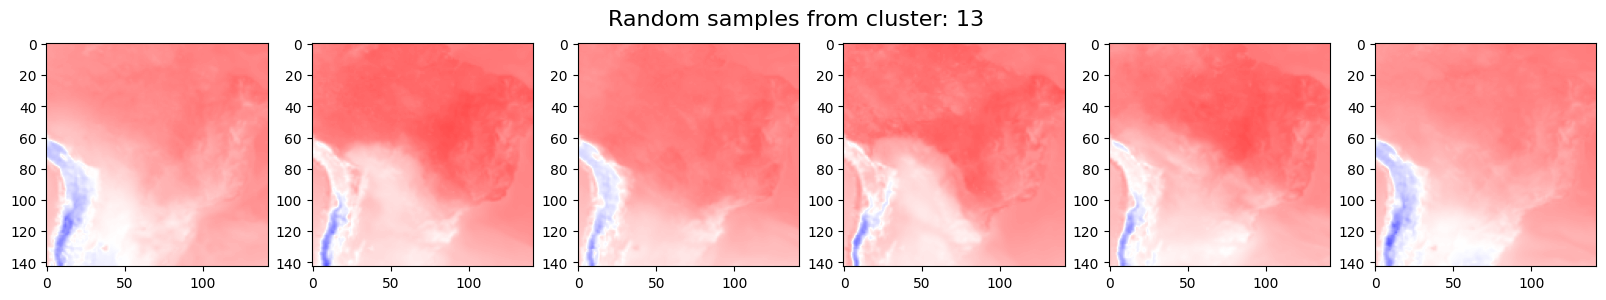

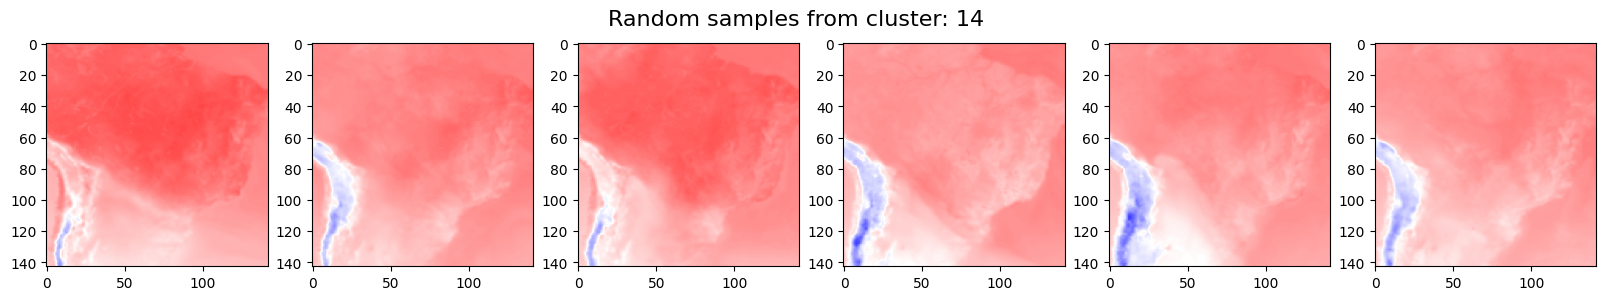

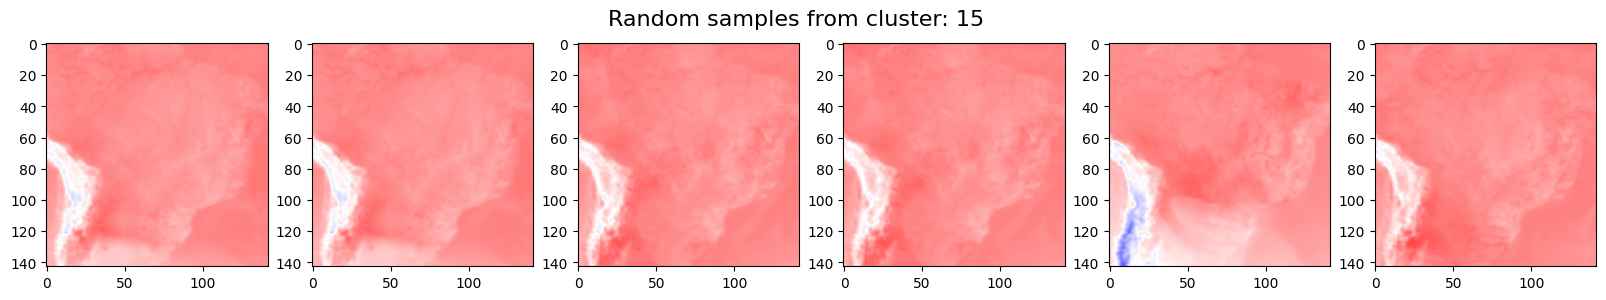

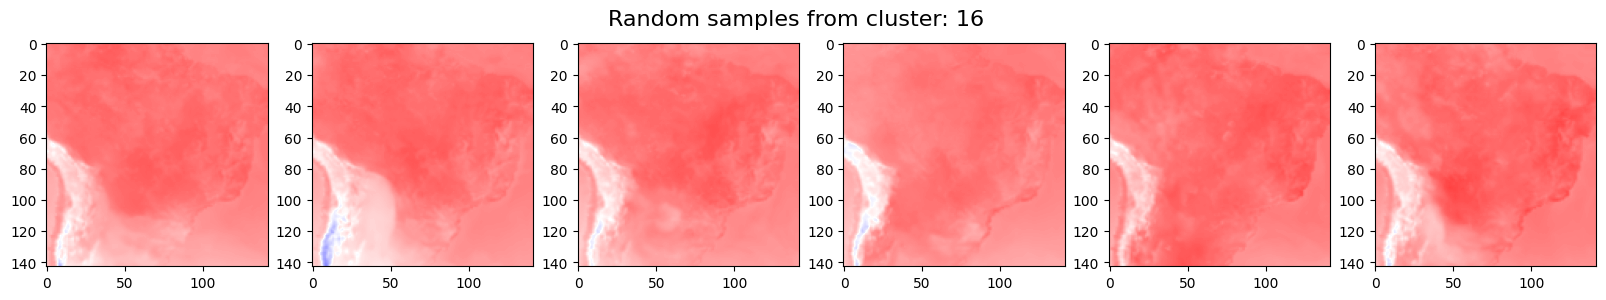

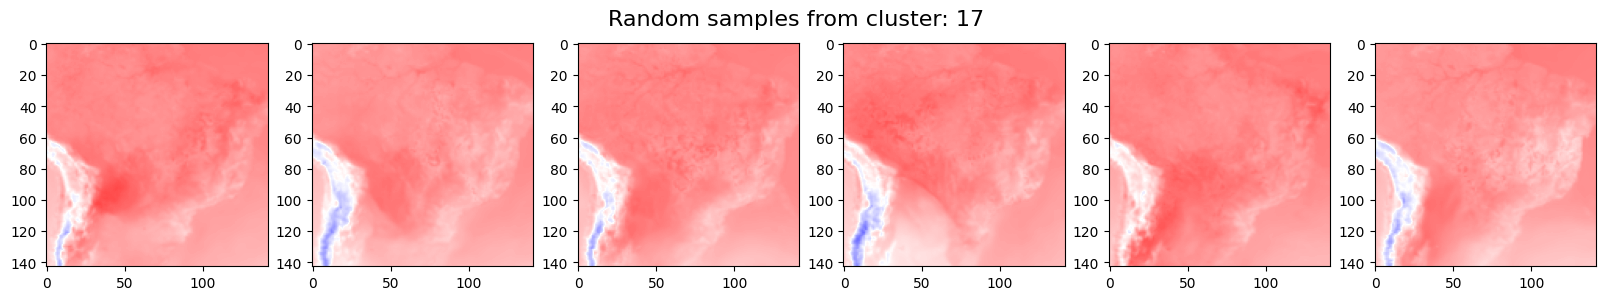

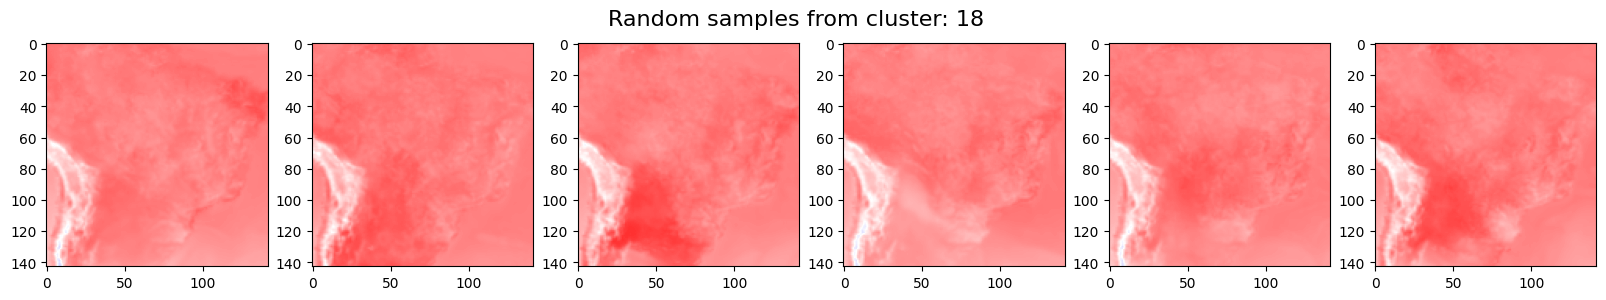

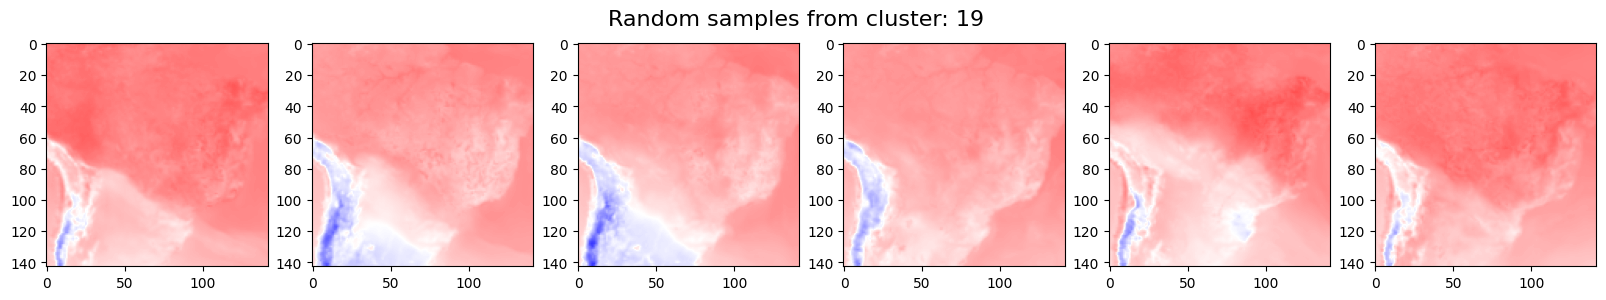

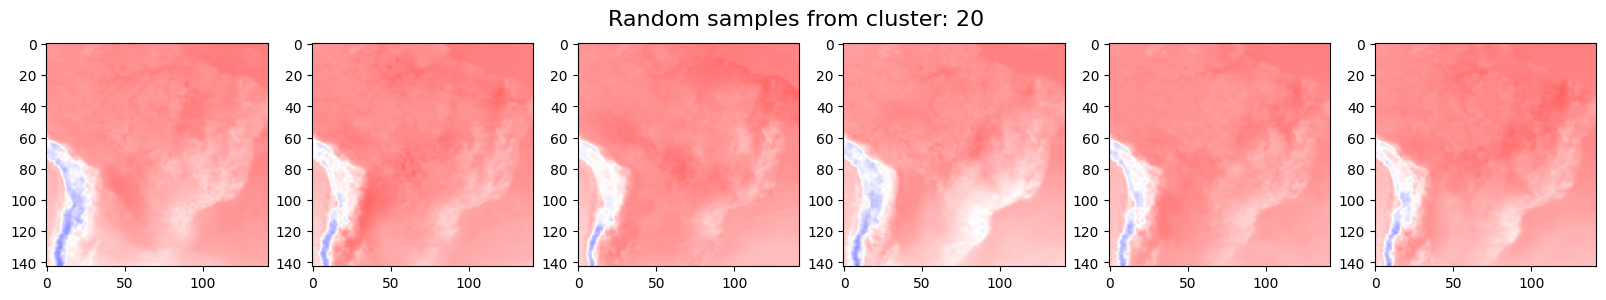

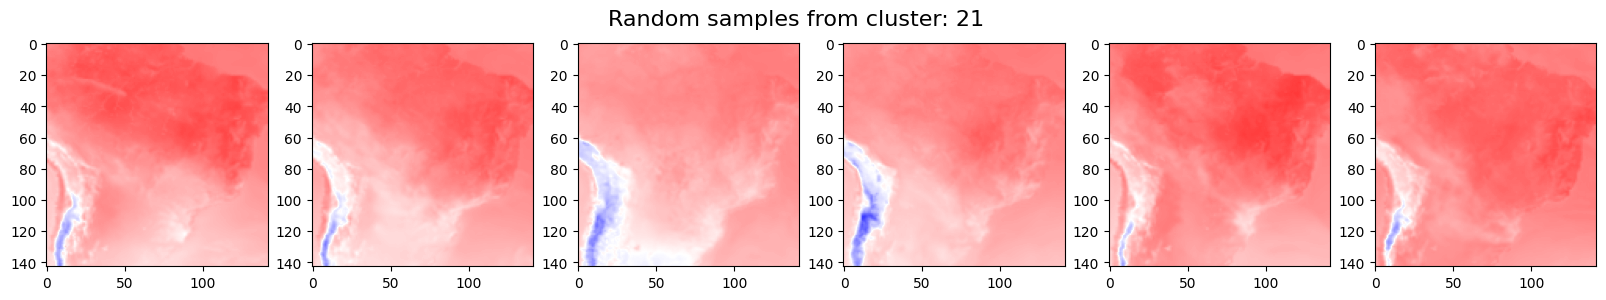

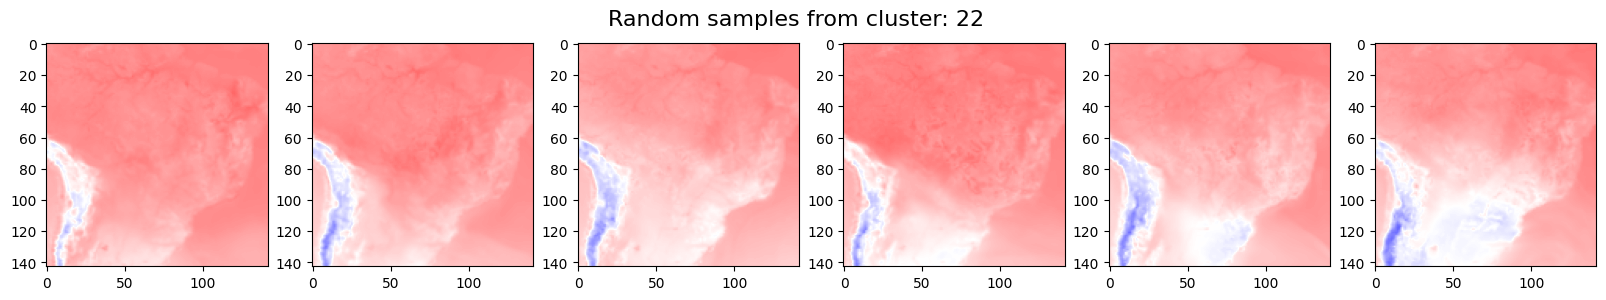

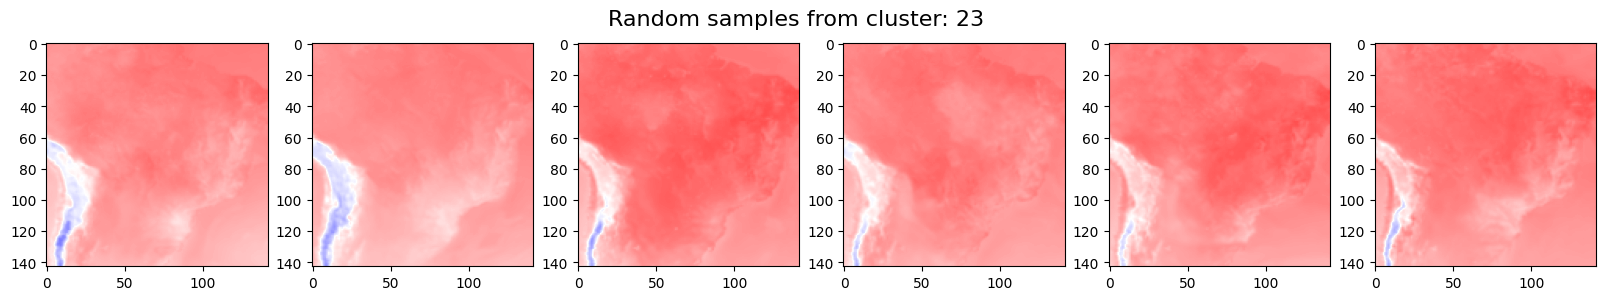

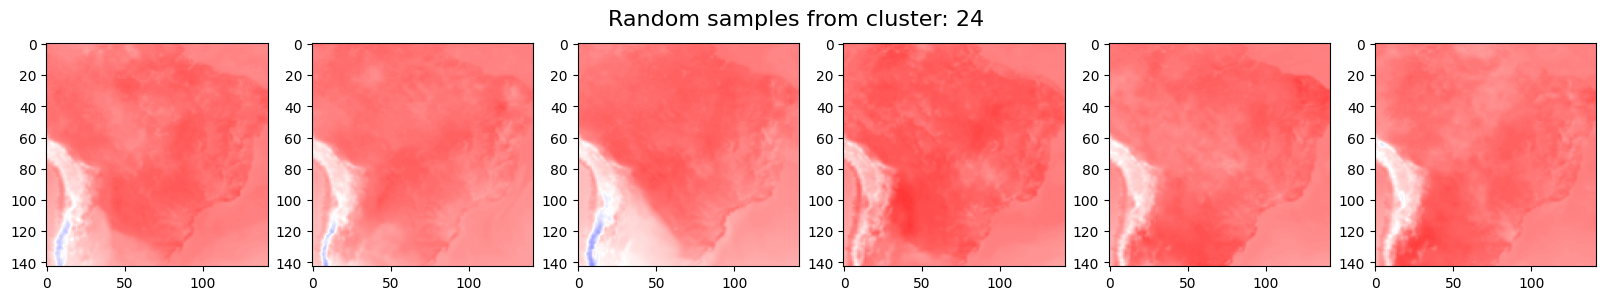

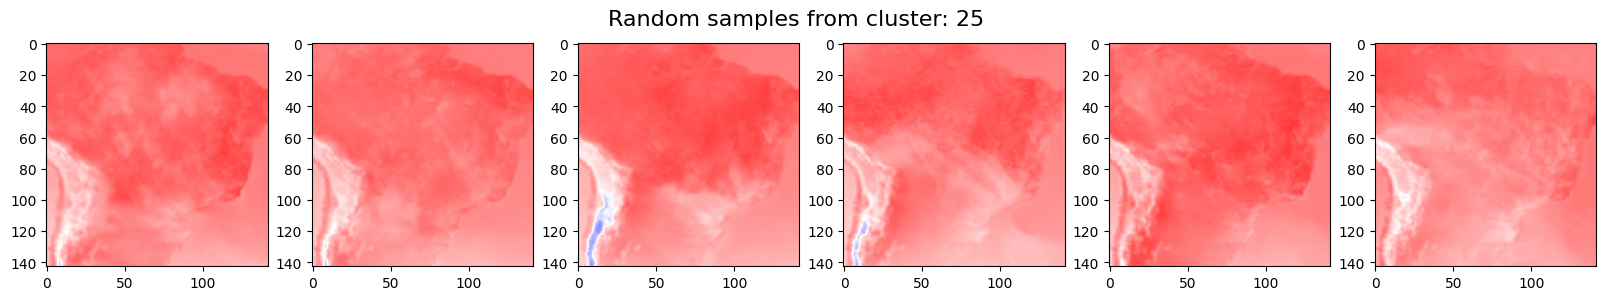

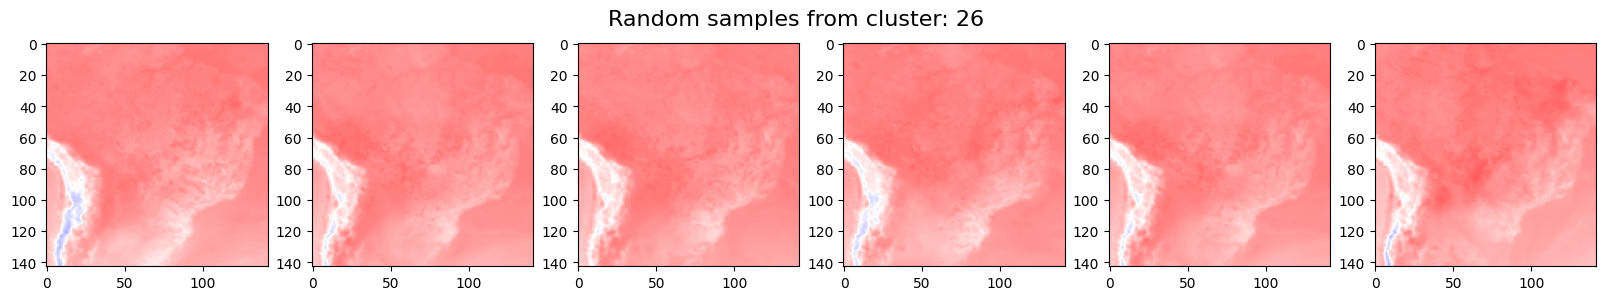

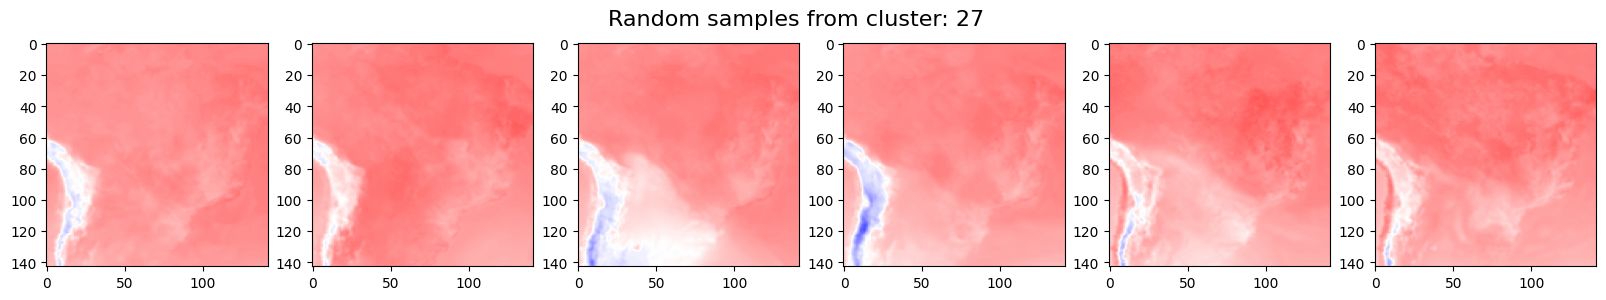

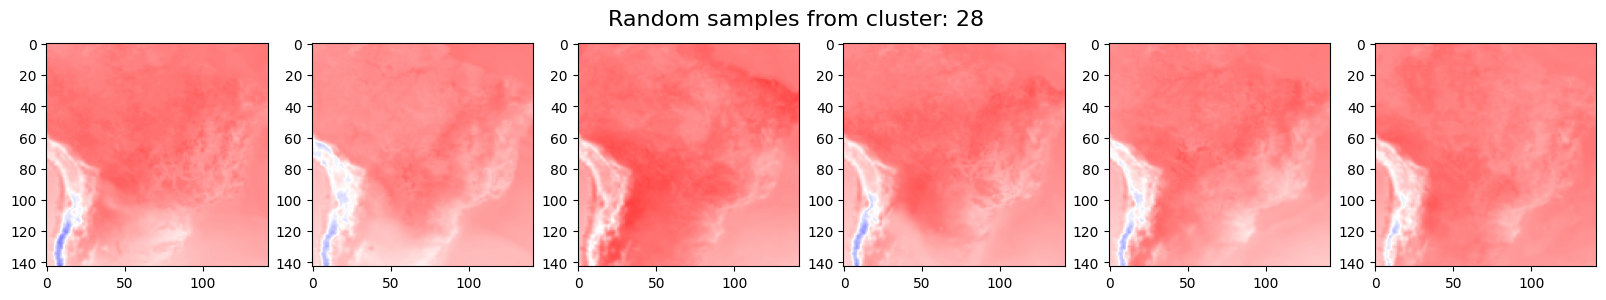

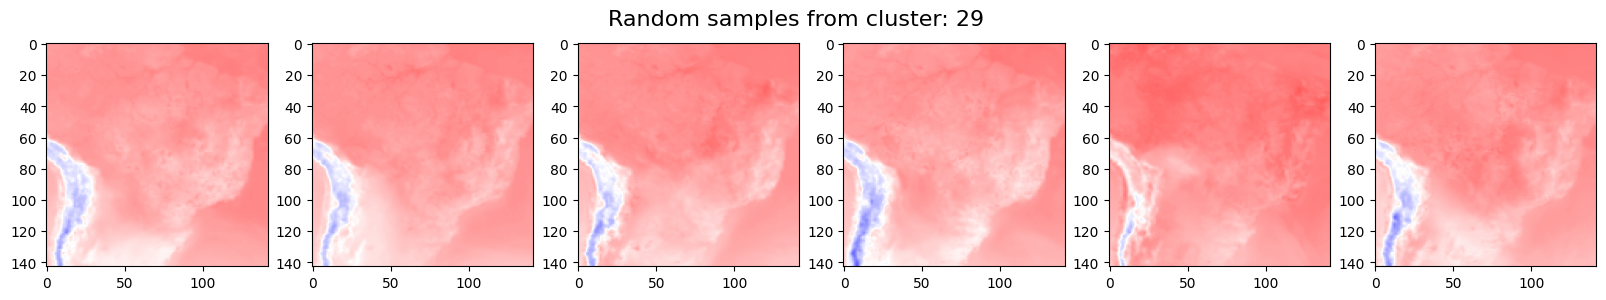

In [133]:
num_samples =  6
for cluster in range(PROTOTYPES):
        
    cluster_indexes = np.where(assignments==cluster)[0]
    samples_indexes = np.random.choice(cluster_indexes,num_samples)

    fig, ax = plt.subplots(1,num_samples,figsize=(20,3))
    fig.suptitle(f"Random samples from cluster: {cluster}", fontsize=16)

    fig.subplots_adjust(wspace=0.2, hspace=0.01)

    for cur_sample in range(num_samples):

        ax[cur_sample].imshow(final_data[samples_indexes[cur_sample]],cmap='bwr',vmin=0, vmax=1)

    plt.show()

El nino

In [237]:
url = "https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt"

elnino = pd.read_csv(url, sep="\s+")
elnino['datetime'] = pd.to_datetime(elnino['YR'].astype(int).astype(str) +\
                                     elnino['MON'].astype(int).astype(str), format='%Y%m')

elnino = elnino.set_index("datetime")[['ANOM']]
elnino.index=pd.to_datetime(elnino.index).to_period("M")

elnino.loc[elnino['ANOM']>0.5,'indicator'] = 1 #el nino
elnino.loc[elnino['ANOM']<-0.5,'indicator'] = 2 #la nina
elnino['indicator'] = elnino['indicator'].fillna(0) #nothing

In [240]:
elnino

ANOM  indicator
datetime                 
1950-01  -1.62        2.0
1950-02  -1.32        2.0
1950-03  -1.07        2.0
1950-04  -1.11        2.0
1950-05  -1.37        2.0
...        ...        ...
2024-03   1.12        1.0
2024-04   0.78        1.0
2024-05   0.24        0.0
2024-06   0.18        0.0
2024-07   0.10        0.0

[895 rows x 2 columns]